# Load, fit, and analyse the waveforms from a PMT

This script contians the required functions to load the PMT outputs from an XML file (outputs of the CAEN software) into a Pandas dataframe, then integrate the waveforms to get an integrated charge, and return the mean value

## Load the required libraries

In [322]:
!pip install -U pip
!pip install lmfit
!pip install pyarrow

In [323]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import pickle
import scipy.signal
import pandas as pd
from os.path import splitext, exists
from lmfit.models import ConstantModel, GaussianModel
from lmfit import Model
from datetime import datetime as dt
import csv
import argparse

## Set up the constants and helper functions

In [324]:
# Resolution of the CAEN digitiser
digi_res = 2 #4 # ns
qhist_bins = 500 #750 # Number of bins to use when fitting and histing qint
peak_prominence_fac = 200 # Prominance will be max value of hist/this

# Charge integration parameters
pre_gate = 5 #3
gate = 15 #50 #155 #35 #15 #12

# Charge fitting parameters
shingo_model = True

#gain_val = 5.76e6 # Gain for he Hamamatsu PMT at 1058 V
gain_val = 4.06e6 # NNVT Gain
 
# Basic physical constants
e_const = 1.602e-19

# What to scale the gain calc by (to get diff units)
# Digitiser resolution in ns, switch to s
# Switch mV to V
# Divide by e to get to gain
gain_scale = digi_res*1e-9*1e-3/e_const

# Resistance of cable
gain_scale /= 50 # Ohm

# for converting [ADC*Sample] to [pC] at plotting
charge_scale = digi_res/50. # 2 [ns] sample ADC, [mV] / 50 ohms in [pC]

In [325]:
parser = argparse.ArgumentParser(description='PMT waveform analysis. WARNING: --show_plots and --save_figs cannot be used together. Same for --q and --dr')
parser.add_argument('--redo_int', action='store_true', help='if you want to re-do the charge integration.')
parser.add_argument('--save', action='store_true', help='Saves the fit information to csv.')
parser.add_argument('--save_plots', action='store_true', help='Saves the qfit and wform plots to the input dir.')
parser.add_argument('--show_plots', action='store_true', help='Shows the plots instead of saving them to file.')
parser.add_argument('--q', action='store_true', help='Integrate peaks to measure gain, PEres/sigma, PV ratio.')
parser.add_argument('--wf', action='store_true', help='Just draw some sample waveforms.')
parser.add_argument('--file', '-f', type=list, help='Input file path')
parser.add_argument('--channels', type=list, help='The labels for each channels (usually which PMT is connected).')
parser.add_argument('--fit_model', type=str, help='luminous')
parser.add_argument('--process_ch', type=str, help='Select a channel number to be processed. (For the LED measurement)')

_StoreAction(option_strings=['--process_ch'], dest='process_ch', nargs=None, const=None, default=None, type=<class 'str'>, choices=None, required=False, help='Select a channel number to be processed. (For the LED measurement)', metavar=None)

In [326]:
def error(x, y, method='+'):
    '''
    Helper function to automatically calculate errors for simple operations
    '''
    z = 0.
    zerr = 0.

    if method == '+':
        z = x[0] + y[0]
        zerr = np.sqrt(x[1]**2 + y[1]**2)
    if method == '-':
        z = x[0] - y[0]
        zerr = np.sqrt(x[1]**2 + y[1]**2)
    if method == '*':
        z = x[0] * y[0]
        zerr = np.sqrt( (x[0]*y[1])**2 + (y[0]*x[1])**2 )
    if method == '/':
        z = x[0] / y[0]
        zerr = np.sqrt( (x[1]/y[0])**2 + ((x[0]*y[1])/(y[0]**2))**2 )

    return (z, zerr)

## Process the files
This is the main function that takes in the arguments (including the file names)
and passes them through the
1. load_wforms 
2. process_wforms 
3. fit_qhist / fit_qhist_luminous 
4. quint_calcs
5. writes the required quantities into an ouput csv file 

In [327]:
def process_files_q(args):
    fnames = args.file
    results = pd.DataFrame()

    now_str = dt.now().strftime("%Y%m%d%H%M%S")
    if args.fit_model == 'luminous':
        csv_name = f"{now_str}_pmt_measurements_luminous.csv"
    else:
        csv_name = f"{now_str}_pmt_measurements.csv"
    csv_file = open(csv_name,'w')
    csv_writer = csv.writer(csv_file)

    # Write the header
    if args.fit_model == 'luminous':
        csv_writer.writerow(["fname","chisqr","charge[pC]","charge_err[pC]",
                             "sigma[pC]","sigma_err[pC]","gain","gain_err"])
    else:
        csv_writer.writerow(["fname","chisqr","gain","gain_err","pv_r",
                             "pv_r_err","sigma[pC]","sigma_err[pC]","pe_res",
                             "pe_res_err"])

    for fname in fnames:
        split_fname = splitext(fname)

        # Load the waveforms
        channels, vrange, vbin_width, trig_window = load_wforms(args,fname)
        ch = args.process_ch
        if ch in channels:
            ch_list = channels[ch].T.values.tolist()
            print("ONLY USING CHANNEL {:s}".format(str(ch)))
        else:
            print('CHANNEL',ch,'IS NOT USED!')
            print('Available channels are:')
            print(channels.keys())
        
        # Integrate waveforms
        qs = integrate_wforms(ch_list, split_fname, vbin_width)

        # Fit the integrated charge histo
        if args.fit_model == 'luminous':
            qfit, qs_hist, qs_bincentres, _, qfit_ax, qfit_fig = fit_qhist_luminous(qs)
        else:
            qfit, qs_hist, qs_bincentres, peaks_i, qfit_ax, qfit_fig = fit_qhist(qs)
        print(f"Chisqr = {qfit.chisqr:g}")

        # Save the fitted charge distribution
        if args.save_plots:
            qfit_fig.savefig(f"{split_fname[0]}_qint.pdf")

        # Calculate and write the measured parameters
        if args.fit_model == 'luminous':
            charge = qfit.best_values['center']*charge_scale
            charge_err = qfit.uvars['center'].std_dev*charge_scale
            sig = qfit.best_values['sigma']*charge_scale
            sig_err = qfit.uvars['sigma'].std_dev*charge_scale
            gain = 1E-12*sig**2 / (charge*e_const)
            gain_err = gain*np.sqrt((2*sig_err/sig)**2 + (charge_err/charge)**2)
            pe_count = (charge*1e-12/(e_const*gain_val), peaks[-1][1]*1e-12/(e_const*gain_val))
            pe_counts_sigma = sig*gain_scale*1e-12/gain

            csv_writer.writerow([fname, qfit.chisqr, charge, charge_err, sig,
                                 sig_err, gain, gain_err])
        else:
            # Calculate based on the peak finder
            gain, pv_r, g1pe_sig, pe_res = qint_calcs(qfit, peaks_i,
                                                      qs_bincentres, qs_hist)
            if gain == -1 and pv_r == -1:
                print("Issues with fit mean file will be skipped.")

            csv_writer.writerow([fname, qfit.chisqr, gain[0], gain[1], pv_r[0],
                                 pv_r[1], g1pe_sig[0], g1pe_sig[1], pe_res[0],
                                 pe_res[1]])

    csv_file.close()
    return

### 1. Load waveforms from pre-processed files
Load waveforms from pre-processed files in a list of lists

In [328]:
def load_wforms(args, fname):
    """
    Opens CAEN digitizer XML output and returns waveforms and digitiser 
    setttings.

    :param str fname: filename of input XML.
    """
    # TODO: #2 split lead_wforms and add capability to load ROOT files
    print("File: %s" % fname)
    split_fname = splitext(fname)

    feather_fname = split_fname[0]+"_wforms.feather"

    print("Parsing XML...")
    # fname may be xml regardless but saves a logic gate
    try:
        tree = ET.parse(fname)
        root = tree.getroot()
        print("... done!")
    except FileNotFoundError:
        print(f"FileNotFoundError: {fname} not found.")
        print("The xml is required for digitiser info, please ensure xml files is"
            "passed (feather will automatically be used).")
        exit()

    # Get voltage range and resolution
    digi = root.find("digitizer")
    vrange_xml = digi.find("voltagerange").attrib
    # Convert strings to floats for hi and low.
    vlow = float(vrange_xml["low"])
    vhi = float(vrange_xml["hi"])
    vrange = (vlow, vhi)

    res = digi.find("resolution").attrib["bits"]
    # Convert bins to charge
    # Get voltage range from digitiser, divide by number of bins (2^number
    # of bits). 
    vbin_width = (vrange[1]-vrange[0])/(2**int(res))
    # Convert to mV
    vbin_width *= 1e3

    res = digi.find("resolution").attrib["bits"]

    # Get the trigger window
    trig_window = root.find("settings").find("window")
    trig_window = float(trig_window.attrib["size"])

    n_channels = int(digi.find("channels").attrib["value"])
    # ith wforms is the list of wforms for channel i of digi
    channels = [[] for i in range(n_channels)]

    # Check if there's a feather file to pull from
    # Skip if this is going to be regenerated
    if exists(feather_fname):
        print("Loading wforms from feather...")
        channels = pd.read_feather(feather_fname)

        # Drop empty channels if there are any
        channels.dropna(how='all', axis=1, inplace=True)

        return channels, vrange, vbin_width, trig_window
    else:
        print('First need to process waveforms!')

### 2. process_wforms 
Integrate the waveforms and output a list of integrated charges

In [329]:
def integrate_wforms(wforms, split_fname, vbin_width):
    
    # Pull integrated charges from file if it exists
    q_fname = split_fname[0] + ".qpkl"
    
    if exists(q_fname) and (not args.redo_int):
        with open(q_fname, "rb") as f:
            qs = pickle.load(f)
        return qs
    
    # Otherwise, calculate
    qs = []
    print("Finding charge integrals...")
    for i,wform in enumerate(wforms):
        try:
            qs.append(quick_qint(wform,vbin_width))
        except IndexError:
            continue
        if (i % 100) == 0:
            print("    %i calculated...\r" % i, end="")
    print("... done! %i calculated." % i)
    with open(q_fname, "wb") as f:
        pickle.dump(qs, f)
    print("Saved to file %s." % q_fname)

    return qs

In [330]:
def quick_qint(wform, vbin_width=1):
    """
    Finds the integral of a pulse, defined by a window around the global
    minimum in the waveform.

    :param np.array wform: Numpy array of the waveform to fit.
    """
    # The upper limit of the search region
    # Peaks are set to be early in the window
    search_region_lim_1 = int(len(wform)/4)
    search_region_lim_2 = int(len(wform)/2)
    peak_i = np.argmin(wform[search_region_lim_1:search_region_lim_2])
    peak_i += search_region_lim_1

    # Define window around centre as peak, size determined by eye.
    peak_wform = wform[(peak_i-pre_gate):(peak_i-pre_gate+gate)]

    # Get baseline from average of all points outside window
    non_peak = np.append(wform[:peak_i-pre_gate], wform[peak_i-pre_gate+gate:])
    # Truncated mean, only use the middle 50% of values.
    non_peak.sort()
    non_peak_lim = int(len(non_peak)/4)
    non_peak = non_peak[non_peak_lim:-non_peak_lim]
    baseline = sum(non_peak)/len(non_peak)

    # Integrate Q from within window, considering baseline
    # Effectively flip, offset to 0, integrate
    # Don't contribute negative charge to the integral.
    peak_wform_mod = [vbin_width*(baseline-x) for x in peak_wform]
    qint = sum(peak_wform_mod)

    return qint

### 3. fit_qhist / fit_qhist_luminous 
Makes a histogram of the integrated charges and fit the PE distribution
to it.
The fit is performed multiple times to find the best positions.
The code is structured as follows:
1. Make the charge histogram
2. Find the peaks using scipy.signal.find_peaks
3. Calculate the seed values for the parameters
4. Do the first fit
5. Use the results of the first fit to seed the second fit and do the second fit
6. Use the results of the second fit to seed the third fit and do the third fit
7. Make a plot of the fitted charge histogram

In [331]:
def fit_qhist(qs, npe=2):
    """
    Fits Gaussians to the integrated charge histogram, fitting the pedestal, 1pe
    and 2pe peaks. Bins within the function.

    :param list of int qs: The integrated charges from each individual waveform.
    :param int npe: The number of pe peaks to fit (not including pedestal).
    :param int or float peak_spacing: The guess at where the **1pe** peak will
        be. Subsequent pe peak guesses will be spaced equally apart.
    :param int or float peak_width: The guess at the sigma of the **1pe** peak.
        Subsequent peaks will be doubled.
    """
    # TODO: #4 Refactor the fit_qhist so it's easier to understand
    # BUG: #5 Fix the fitting seeds so the fit works

    # Get the charge histogram
    qs_hist, qs_binedges = get_qhist(qs)

    # Get centre of bins instead of edges
    bin_width = qs_binedges[1]-qs_binedges[0]
    # Includes all edges, get rid of last edge
    qs_bincentres = qs_binedges[:-1] + (bin_width/2)

    # Find peaks, with fairly stringent prominence requirement, and distance
    # being greater than 0.1 the total span of the hist.
    peaks_i = scipy.signal.find_peaks(qs_hist, 
        prominence=max(qs_hist)/peak_prominence_fac,
        distance = qhist_bins/10,
        width=qhist_bins/100
        )[0]

    # Get actual peak positions instead of just indices
    #peaks = [x*bin_width+qs_bincentres[0] for x in peaks_i] #orig
    peaks = np.array(qs_bincentres)[peaks_i]

    npe = len(peaks)+1
    
    print('peaks_i', peaks_i)
    print('peaks:', peaks)
    print('npe', npe)

    # Use found peaks to estimate pedestal width and spacing
    # This may be overwritten
    if len(peaks) > 1:
        peak_width = 0.05*(peaks[1] - peaks[0])
        peak_spacing = peaks[1] - peaks[0]

        min_centre = 0.9
        max_centre = 1.3
        min_width = 0.5
    else:
        peak_width = 0.02*max(qs_bincentres) #Shingo
        peak_spacing = 0.3*max(qs_bincentres) #orig - Shingo

        # Loosen limits on centre if only one peak found
        min_centre = 0.5
        max_centre = 2 # Shingo
        min_width = 0

    max_widths = [4, 1.] #Shingo's
    max_widths.extend([2]*(npe-1))
    
    print('peak_width',peak_width)
    print('min_width', min_width)
    print('max_widths', max_widths)
    print('peak_spacing', peak_spacing)
    print('min_centre', min_centre)
    print('max_centre', max_centre)
    
    # Iteratively add npe pe peaks to fit
    for i in range(npe):
        # First peak has width of peak_width, subsequent peaks will double in
        # width each time.
        # Will be overidden if peaks were found.
        width = peak_width*(2**i)

        if i < len(peaks):
            # If this peak was found, use them as starting guesses
            center = peaks[i]

            # Use spacing if on at least 1pe peak
            if i > 0:
                spacing = peaks[i] - peaks[i-1]
                width = spacing/3
        elif (len(peaks) > 1) and (i == len(peaks)):
            print('else 1')
            # If the peak to fit is one beyond the peaks found,
            # predict center using previous peak spacing
            prev_spacing = peaks[i-1] - peaks[i-2]
            center = peaks[i-1] + prev_spacing

            # Get height by getting the index, again from prev spacing
            prev_spacing_i = peaks_i[i-1] - peaks_i[i-2]

            # Assume width is double the previous peak spacing
            width = prev_spacing/2
        else:
            print('else 2')
            # Otherwise, just use the peak_spacing
            center = i*peak_spacing
            width = 4. # temporary
            
        print('center', center)
        print('width', width)
        # Just take the height at the centre guess, get index from
        # converting peak_spacing into index spacing
        center_i_calc = int((center-qs_bincentres[0])/bin_width)
        height = qs_hist[center_i_calc]
        
        # Calc amplitude from gaussian calc.
        # Doesn't perfectly line up but oh well.
        amp = height
        if center_i_calc>=3:
            min_amp = np.min(qs_hist[center_i_calc-3:center_i_calc+3])
            max_amp = np.max(qs_hist[center_i_calc-3:center_i_calc+3])
        else:
            min_amp = np.min(qs_hist[:center_i_calc+3])
            max_amp = np.max(qs_hist[:center_i_calc+3])
        
        if i==0:
            centre_i_calc0 = center_i_calc
            
            amp0, min_amp0, max_amp0 = amp, min_amp*0.8, max_amp*1.2
            centre0, min_centre0, max_centre0 = center, min_centre*center, max_centre*center
            sigma0, min_sigma0, max_sigma0 = width, min_width*width, max_widths[i]*width
            sigma0, min_sigma0, max_sigma0 = 0.0872, 0.0872*0.9, 0.0872*1.1 # template
        elif i==1:
            centre_i_calc1 = center_i_calc
            amp1, min_amp1, max_amp1 = amp, min_amp, amp0*0.9 #max_amp*1000.
            centre1, min_centre1, max_centre1 = center, min_centre*center, max_centre*center
            sigma1, min_sigma1, max_sigma1 = width, min_width*width, max_widths[i]*width    

            famp2, min_famp2, max_famp2 = 0.05, 0.01, 0.1
            famp3, min_famp3, max_famp3 = 0.05, 0.01, 0.1

    if shingo_model:
        alpha = np.log(0.2)/(centre0-centre1)
        min_alpha = alpha*0.5
        max_alpha = alpha*2.0
        w = amp1/alpha*1e-5
        min_w = w*0.1
        max_w = w*10.0

    qs_hist = np.array(qs_hist)
    qs_bincentres = np.array(qs_bincentres)


    
    ### 1st fit without exp ###
    model = Model(fullPEfunction, nan_policy='omit')
    model.set_param_hint('amp0', value=amp0, min=min_amp0, max=max_amp0)
    model.set_param_hint('centre0', value=centre0, min=min_centre0, max=max_centre0)
    model.set_param_hint('sigma0', value=sigma0, max=max_sigma0)

    model.set_param_hint('amp1', value=amp1, min=min_amp1, max=max_amp1)
    model.set_param_hint('centre1', value=centre1, min=min_centre1, max=max_centre1)
    model.set_param_hint('sigma1', value=sigma1, min=min_sigma1, max=max_sigma1)

    model.set_param_hint('famp2', value=famp2, min=min_famp2, max=max_famp2)
    model.set_param_hint('famp3', value=famp3, min=min_famp3, max=max_famp3)
    model.set_param_hint('alpha', value=alpha, min=min_alpha, max=max_alpha)
    model.set_param_hint('w', value=w, min=min_w, max=max_w)

    # Make the params of the model
    params = model.make_params()
    print('params1', params)
    # Scale x to fit to real time values
    qfit = model.fit(qs_hist, params, x=qs_bincentres, method='least_squares')
    print('params2', qfit.params)



    ### ###
    ### 2nd fit with exp between pedestal and 1pe peak ###
    amp0        = qfit.best_values['amp0']
    std_amp0    = qfit.uvars['amp0'].std_dev
    centre0     = qfit.best_values['centre0']
    std_centre0 = qfit.uvars['centre0'].std_dev
    sigma0      = qfit.best_values['sigma0']
    std_sigma0  = qfit.uvars['sigma0'].std_dev
    amp1        = qfit.best_values['amp1']
    std_amp1    = qfit.uvars['amp1'].std_dev
    centre1     = qfit.best_values['centre1']
    std_centre1 = qfit.uvars['centre1'].std_dev
    sigma1      = qfit.best_values['sigma1']
    std_sigma1  = qfit.uvars['sigma1'].std_dev
    famp2       = qfit.best_values['famp2']
    std_famp2   = qfit.uvars['famp2'].std_dev
    min_famp2   = famp2-std_famp2 if (famp2-std_famp2)>0 else 0.0
    famp3       = qfit.best_values['famp3']
    std_famp3   = qfit.uvars['famp3'].std_dev
    min_famp3   = famp3-std_famp3 if (famp3-std_famp3)>0 else 0.0

    alpha = np.log(0.2)/(centre0-centre1)
    min_alpha = alpha*0.05
    max_alpha = alpha*2.0
    w = amp1/alpha*0.05
    min_w = w*0.01
    max_w = w*10.0

    model = Model(fullPEfunction, nan_policy='omit')

    model.set_param_hint('amp0', value=amp0, min=amp0-std_amp0, max=amp0)
    model.set_param_hint('centre0', value=centre0, min=centre0-std_centre0, max=centre0+std_centre0)
    model.set_param_hint('sigma0', value=sigma0, min=sigma0-1e-6, max=sigma0+1e-6)
    model.set_param_hint('amp1', value=amp1, max=amp1)
    model.set_param_hint('centre1', value=centre1, min=centre1-std_centre1, max=centre1+std_centre1)
    model.set_param_hint('sigma1', value=sigma1, min=sigma1-std_sigma1, max=sigma1+std_sigma1)        
    model.set_param_hint('famp2', value=famp2, min=min_famp2, max=famp2+std_famp2)
    model.set_param_hint('famp3', value=famp3, min=min_famp3, max=famp3+std_famp3)
    model.set_param_hint('alpha', value=alpha, min=min_alpha, max=max_alpha)
    model.set_param_hint('w', value=w, min=min_w, max=max_w)

    params = model.make_params()
    print('params3', params)


    pe0_hist = gaussian(qs_bincentres, amp0, centre0, sigma0)
    pe1_hist = gaussian(qs_bincentres, amp1, centre1, sigma1)
    cross_point = (pe1_hist>pe0_hist) & (qs_bincentres>centre0)
    qs_bincentres_ped_to_2pe = qs_bincentres[ cross_point & (qs_bincentres<(2*centre1-1*centre0)) ]
    qs_hist_ped_to_2pe = qs_hist[ cross_point & (qs_bincentres<(2*centre1-1*centre0)) ]
    qfit = model.fit(qs_hist_ped_to_2pe, params, x=qs_bincentres_ped_to_2pe, method='least_squares')
    print('params4', qfit.params)
    ### ###


    
    ### 3rd fit ###
    amp1        = qfit.best_values['amp1']
    try : std_amp1 = qfit.uvars['amp1'].std_dev
    except AttributeError: std_amp1 = std_amp1
    centre1     = qfit.best_values['centre1']
    try : std_centre1 = qfit.uvars['centre1'].std_dev
    except AttributeError: std_centre1 = std_centre1
    sigma1      = qfit.best_values['sigma1']
    try : std_sigma1 = qfit.uvars['sigma1'].std_dev
    except AttributeError: std_sigma1 = std_sigma1

    alpha     = qfit.best_values['alpha']
    std_alpha = alpha*0.001
    w         = qfit.best_values['w']
    std_w = w* 0.001

    model = Model(fullPEfunction, nan_policy='omit')

    model.set_param_hint('amp0', value=amp0,max= amp0)# min=amp0-std_amp0, max=amp0)
    model.set_param_hint('centre0', value=centre0, min=centre0-std_centre0, max=centre0+std_centre0)
    model.set_param_hint('sigma0', value=sigma0, min=sigma0-std_sigma0, max=sigma0+std_sigma0)
    model.set_param_hint('amp1', value=amp1,max=amp1)# min=amp1-std_amp1, max=amp1)
    model.set_param_hint('centre1', value=centre1, min=centre1-std_centre1, max=centre1+std_centre1)
    model.set_param_hint('sigma1', value=sigma1, min=sigma1-std_sigma1, max=sigma1+std_sigma1)        
    model.set_param_hint('famp2', value=0.05, min=0.01, max=0.1)#+std_famp2)
    model.set_param_hint('famp3', value=0.05, min=0.01, max=0.1)#+std_famp3)
    model.set_param_hint('alpha', value=alpha, min=alpha-std_alpha, max=alpha+std_alpha)
    model.set_param_hint('w', value=w, min=w-std_w, max=w+std_w)

    params = model.make_params()
    print('params5', params)
    qfit = model.fit(qs_hist, params, x=qs_bincentres, method='least_squares')
    print('params6', qfit.params)
    print('params', qfit.params)
    ### ###


    # Plot the results of the fit and the peaks
    qfit_fig, qfit_ax = plot_fit_qhist(qs_hist, qs_bincentres, qfit)
    qfit_ax.vlines(peaks, 0, max(qs_hist), colors="grey", linestyles="--", 
        alpha=0.5)
    qfit_ax.legend()

    # Have to return ax and fig to set title to fname.
    # Or could take plot title here instead.
    return qfit, qs_hist, qs_bincentres, peaks_i, qfit_ax, qfit_fig

In [332]:
def get_qhist(qs):
  '''
  Calculate the area normalized charge histogram in units of pC
  '''
  # Get rid of qs where calculation is perfectly 0 for some reason
  qs_filter = [q*charge_scale for q in qs if q != 0]
  #
  # Bin the integrated charges
  qs_hist, qs_binedges = np.histogram(qs_filter, bins=qhist_bins)

  # Get rid of tiny bins by removing bins with less than qs_cut_thresh in
  qs_cut_thresh = min(np.array(qs_hist)[np.array(qs_hist)>0.])*3.0 # 3event
  trim_range = [np.where(qs_hist>qs_cut_thresh)[0][0],
                np.where(qs_hist>qs_cut_thresh)[0][-1]]
  hist_range = [qs_binedges[trim_range[0]], qs_binedges[trim_range[1]]]

  # Re-do the histogram to preserve the intended number of bins
  qs_hist, qs_binedges = np.histogram(qs_filter, bins=qhist_bins, range=(hist_range[0],hist_range[1]))

  # Get centre of bins
  bin_width = qs_binedges[1]-qs_binedges[0]

  # Scale bin values to area normalise to 1
  qs_hist = qs_hist/(sum(qs_hist)*bin_width)

  return qs_hist, qs_binedges

In [333]:
#https://lmfit.github.io/lmfit-py/model.html#lmfit.model.Model
def gaussian(x, amp, centre, sigma):
    #return (amp/(sigma*np.sqrt(2*np.pi)))*np.exp(-np.power(x-centre,2)/(2*np.power(sigma,2)))
    return amp*np.exp(-np.power(x-centre,2)/(2*np.power(sigma,2)))

def exp_bg(x, alpha, w):
    f = w*alpha*np.exp(-alpha*x)
    f[np.where(x<0.)] = 0.
    return f

def fullPEfunction(x, amp0, centre0, sigma0, amp1, centre1, sigma1, famp2, famp3, alpha, w):
    f = gaussian(x, amp0, centre0, sigma0) +\
        gaussian(x, amp1, centre1, sigma1) +\
        gaussian(x, amp1*famp2, (2*centre1-centre0), 1.414*sigma1) +\
        gaussian(x, amp1*famp2*famp3, (3*centre1-centre0), 2.436*sigma1) +\
        exp_bg((x-centre0), alpha, w)
    return f

In [334]:
def plot_fit_qhist(qs_hist, qs_bincentres, qfit):
    # Get each individual component of the model
    components = qfit.eval_components()

    qfit_fig, qfit_ax = plt.subplots()
    qfit_fig.set_size_inches(14,8)

    qs_bincentres_pC = qs_bincentres#*charge_scale
    bin_width_pC = qs_bincentres_pC[1]-qs_bincentres_pC[0]
    
    qfit_ax.bar(qs_bincentres_pC, qs_hist, width=bin_width_pC, label="Data", alpha=0.5)
    qfit_ax.plot(qs_bincentres_pC, qfit.best_fit, label="Best Fit (Composite)")
    if shingo_model:
        pe0 = gaussian(qs_bincentres, qfit.best_values['amp0'], qfit.best_values['centre0'], qfit.best_values['sigma0'])
        pe1 = gaussian(qs_bincentres, qfit.best_values['amp1'], qfit.best_values['centre1'], qfit.best_values['sigma1'])
        pe2 = gaussian(qs_bincentres, qfit.best_values['amp1']*qfit.best_values['famp2'], 2*qfit.best_values['centre1']-qfit.best_values['centre0'], 1.414*qfit.best_values['sigma1'])
        pe3 = gaussian(qs_bincentres, qfit.best_values['amp1']*qfit.best_values['famp2']*qfit.best_values['famp3'], 3*qfit.best_values['centre1']-qfit.best_values['centre0'], 2.436*qfit.best_values['sigma1'])
        exp = exp_bg(qs_bincentres-qfit.best_values['centre0'], qfit.best_values['alpha'], qfit.best_values['w'])
        
        qfit_ax.plot(qs_bincentres_pC, pe0, label='0pe')
        qfit_ax.plot(qs_bincentres_pC, pe1, label='1pe')
        qfit_ax.plot(qs_bincentres_pC, pe2, label='2pe')
        qfit_ax.plot(qs_bincentres_pC, pe3, label='3pe')
        qfit_ax.plot(qs_bincentres_pC, exp, label='exp_bg')
    else:
        # Plot each component/submodel
        for name, sub_mod in components.items():
            try:
                # Get rid of underscore on prefix for submod name
                qfit_ax.plot(qs_bincentres_pC, sub_mod, label=name[:-1])
            except ValueError:
                # For constant model, sub_mod isn't list
                # Don't use hlines, use plot to keep colours in order
                qfit_ax.plot([qs_bincentres_pC[0],qs_bincentres_pC[-1]], [sub_mod]*2, 
                    label=name[:-1])

    # Set lower limit to half a bin to avoid weird scaling
    # Remembering it's area normalised
    qfit_ax.set_ylim(bottom=0.5E-3)
    qfit_ax.set_yscale("log")
    qfit_ax.set_ylabel('Area Normalized (arb. units)')
    qfit_ax.set_xlabel('Charge [pC]')

    return qfit_fig, qfit_ax

In [335]:
def fit_qhist_luminous(qs):
    # TODO: #3 Clean up fit_qhist_luminous
    # Get rid of qs where calculation is perfectly 0 for some reason
    qs_filter = [q for q in qs if q != 0]
    
    # Bin the integrated charges 
    qs_hist, qs_binedges = np.histogram(qs_filter, bins=qhist_bins)

    # Get centre of bins instead of edges
    bin_width = qs_binedges[1]-qs_binedges[0]

    # Includes all edges, get rid of last edge
    qs_bincentres = qs_binedges[:-1] + (bin_width/2)

    # Get rid of tiny bins by removing bins with less than qs_cut_thresh in
    #qs_bincentres_cut = []
    #qs_hist_cut = []
    #qs_cut_thresh = max(qs_hist)/1e4
    #for bincent, q in zip(qs_bincentres, qs_hist):
    #    if q > qs_cut_thresh:
    #        qs_bincentres_cut.append(bincent)
    #        qs_hist_cut.append(q)
    #qs_hist = [x for x in qs_hist_cut]
    #qs_bincentres = [x for x in qs_bincentres_cut]
    ## updated by shingo Feb. 2024
    qs_cut_thresh = min(np.array(qs_hist)[np.array(qs_hist)>0.])*1.0 # 1event
    
    #qs_hist = np.array(qs_hist)
    trim_range = [np.where(qs_hist>qs_cut_thresh)[0][0], np.where(qs_hist>qs_cut_thresh)[0][-1]]
    
    qs_bincentres = qs_bincentres[trim_range[0] : trim_range[1]]
    qs_hist = qs_hist[trim_range[0] : trim_range[1]]

    # Scale bin values to area normalise to 1
    qs_hist = qs_hist/(sum(qs_hist)*bin_width)
    
    np.save('qs_hist.npy',np.array(qs_hist))
    np.save('qs_bincentres.npy', np.array(qs_bincentres))

    # Find a peak
    peak_height = qs_hist.max()
    peak_i = qs_hist.argmax()
    centre   = np.array(qs_bincentres)[peak_i]

    print('peak_height', peak_height)
    print('peak_i', peak_i)
    print('centre', centre)

    qs_hist = np.array(qs_hist)
    qs_bincentres = np.array(qs_bincentres)
    
    model = GaussianModel()
    params = model.guess(qs_hist, x=qs_bincentres)
    qfit = model.fit(qs_hist, params, x=qs_bincentres, method='least_squares')

    print('params', qfit.params)

    # Get each individual component of the model
    components = qfit.eval_components()

    qfit_fig, qfit_ax = plt.subplots()
    qfit_fig.set_size_inches(14,8)
    
    qs_bincentres_pC = qs_bincentres*charge_scale
    bin_width_pC = bin_width*charge_scale

    qfit_ax.bar(qs_bincentres_pC, qs_hist, width=bin_width_pC, label="Data", alpha=0.5)
    qfit_ax.plot(qs_bincentres_pC, qfit.best_fit, label="Gaussian Fit")

    qfit_ax.vlines(qfit.best_values['center']*charge_scale, 0, max(qs_hist), colors="grey", linestyles="--", alpha=0.5,label='Mean=%.2f pC' % (qfit.best_values['center']*charge_scale))
    qfit_ax.legend()
    #qfit_ax.set_ylim(bottom=0.1/len(qs))
    #qfit_ax.set_yscale("log")
    qfit_ax.set_ylabel('Area normalized')
    qfit_ax.set_xlabel('Deposited Charge [pC]')

    return qfit, qs_hist, qs_bincentres, peak_i, qfit_ax, qfit_fig    



### 4. quint_calcs 
Calculate the required quantities (such as gain, peak-to-valley ratio,
 ...) form the fit to the integrated charge histogram

In [336]:
def qint_calcs(qfit, peaks_i, qs_bincentres, qs_hist):
    """
    Calculates gain, peak-to-valley ratio and Single PE resolution from the peaks and fits.

    :param lmfit.model.ModelResult qfit: The fit of the integrated charge histo.
    :param list or array of ints peaks_i: The indices of the peaks in qhist,
        starting with the pedestal (0pe).
    :param list or array of floats qs_bincentres: The centres of the qhist bins.
    :param list or array of floats qs_hist: The values of the qhist bins.
    """
    
    if shingo_model:
        gped_val = qfit.best_values["centre0"]
        gped_val_error = qfit.uvars['centre0'].std_dev
        g1pe_val = qfit.best_values["centre1"]
        g1pe_val_error = qfit.uvars["centre1"].std_dev
        g1pe_sig = qfit.best_values["sigma1"]
        g1pe_sig_error = qfit.uvars["sigma1"].std_dev
    else:
        gped_val = qfit.best_values["g0pe_center"]
        gped_val_error = qfit.uvars['g0pe_center'].std_dev
        g1pe_val = qfit.best_values["g1pe_center"]
        g1pe_val_error = qfit.uvars["g1pe_center"].std_dev
        g1pe_sig = qfit.best_values["g1pe_sigma"]
        g1pe_sig_error = qfit.uvars["g1pe_sigma"].std_dev
    
    # Gain is just average integrated charge for 1pe vs none.
    gain = error((g1pe_val, g1pe_val_error), (gped_val, gped_val_error), method='-')
    gain = error(gain, (gain_scale, 0.), method='*')
    print(f"Gain = {gain[0]:g} +/- {gain[1]:g}")

    # Peak-to-valley is ratio of 1pe peak to valley between 1pe and pedestal. 
    # Compute from fitting result
    peak_1pe = qfit.eval(x=[g1pe_val])[0]
    peak_1pe_error = qfit.eval_uncertainty(sigma=1, x=[g1pe_val])[0]
    x_0pe_to_1pe = [ gped_val + i*(g1pe_val-gped_val)/1000. for i in range(1000)]
    best_0pe_to_1pe = qfit.eval(x=x_0pe_to_1pe)
    std_0pe_to_1pe = qfit.eval_uncertainty(sigma=1, x=x_0pe_to_1pe)
    valley = best_0pe_to_1pe.min()
    valley_error = std_0pe_to_1pe[best_0pe_to_1pe.argmin()]
    print('peak_1pe',peak_1pe)
    print('peak_1pe_error', peak_1pe_error)
    print('valley', valley)
    print('valley_error', valley_error)
    pv_r = error( (peak_1pe, peak_1pe_error), (valley, valley_error), method='/' )
    print('pv_r, err_pv_r', pv_r)
    # TODO: #6 Implement and check the peak-to-valley ratio from histograms
    '''
    # Get valley from minimum of qs_hist between the two peaks
    # Subset qs_hist using qs_bincentres
    qs_hist_pedto1pe = [x for x in zip(qs_bincentres,qs_hist) 
        if x[0] > gped_center and x[0] < g1pe_center]
    # Get min from this subset
    if len(qs_hist_pedto1pe) == 0:
        print("Failed to calculate valley height!"
            " No data between ped and 1pe peak, maybe 1pe failed to fit?")
        h_v = None
    else:
        h_v = min([x[1] for x in qs_hist_pedto1pe])
    
    # Don't want to use the actual gaussian amplitude here as this is for peak
    # determination quality.
    # Find peak between the ped and 2pe centres (half the distance between them)
    qhist_1pe_peak_lo = (g1pe_center - gped_center)/2
    # Use second peak if it's fitted, if not just half beyond the 1pe peak
    if two_peaks_fitted:
        qhist_1pe_peak_hi = (g2pe_center - g1pe_center)/2
    else:
        qhist_1pe_peak_hi = 1.5*g1pe_center
    qs_hist_1pe_peak_scan = [x for x in zip(qs_bincentres,qs_hist) 
        if x[0] > qhist_1pe_peak_lo and x[0] < qhist_1pe_peak_hi]
    if len(qs_hist_1pe_peak_scan) == 0:
        print("Failed to calculate peak height!"
            " No data around 1pe peak, maybe 1pe failed to fit?")
        h_p = None
    else:
        h_p = max([x[1] for x in qs_hist_1pe_peak_scan])

    if h_p is not None and h_v is not None:
        pv_r = h_p/h_v
        print(f"Peak-to-valley ratio = {pv_r:g}")
    else:
        pv_r = None
    '''

    # PE resolution uses the actual fit gaussian
    pe_res = error( (g1pe_sig, g1pe_sig_error), (g1pe_val, g1pe_val_error), method='/')
    pe_res = error( pe_res, (100, 0), method='*')
    print(f"PE Resolution = {pe_res[0]:g} +/- {pe_res[1]:g}")

    # Now scale the single PE sigma to charge
    g1pe_sig *= charge_scale
    g1pe_sig_error *= charge_scale
    print(f"1PE Sigma = {g1pe_sig:g} +/ {g1pe_sig_error}")

    return gain, pv_r, (g1pe_sig, g1pe_sig_error), pe_res


## Load the files and run the code

In [337]:
### LED measurement
files = [
    #'../../data/2024-02-22_LED/HAM_KM56213_900v.xml',
    #'../../data/2024-02-22_LED/HAM_KM56213_950v.xml',
    #'../../data/2024-02-22_LED/HAM_KM56213_1000v.xml',
    #'../../data/2024-02-22_LED/HAM_KM56213_1050v.xml',
    #'../../data/2024-02-22_LED/HAM_KM56213_1100v.xml',
    #'../../data/2024-02-22_LED/HAM_KM56213_1150v.xml',
    #'../../data/2024-02-22_LED/HAM_KM56213_1200v.xml',
    #'../../data/2024-02-22_LED/HAM_KM56213_1250v.xml',
    #'../../data/2024-02-22_LED/HAM_KM56213_1300v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2305-1100_900v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2305-1100_950v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2305-1100_1000v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2305-1100_1050v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2305-1100_1100v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2305-1100_1150v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2305-1100_1200v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2305-1100_1250v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2305-1100_1300v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2304-1470_900v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2304-1470_950v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2304-1470_1000v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2304-1470_1050v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2304-1470_1100v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2304-1470_1150v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2304-1470_1200v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2304-1470_1250v.xml',
    #'../../data/2024-02-22_LED/NNVT_PN2304-1470_1300v.xml',
    #'../../data/2024-02-22_LED/HAM_KM56206_900v.xml',
    #'../../data/2024-02-22_LED/HAM_KM56206_950v.xml',
    #'../../data/2024-02-22_LED/HAM_KM56206_1000v.xml',
    #'../../data/2024-02-22_LED/HAM_KM56206_1050v.xml',
    #'../../data/2024-02-22_LED/HAM_KM56206_1100v.xml',
    #'../../data/2024-02-22_LED/HAM_KM56206_1150v.xml',
    #'../../data/2024-02-22_LED/HAM_KM56206_1200v.xml',
    #'../../data/2024-02-22_LED/HAM_KM56206_1250v.xml',
    #'../../data/2024-02-22_LED/HAM_KM56206_1300v.xml'
    ]

### ###

### Angular dependence ###
files000 = [
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az000Pol00.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az000Pol15.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az000Pol30.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az000Pol40.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az000Pol50.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az000Pol60.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az000Pol70.xml'
]
files030 = [
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az030Pol60.xml',
]
files090 = [
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az090Pol00.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az090Pol15.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az090Pol30.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az090Pol40.xml',
    #'/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az090Pol45.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az090Pol50.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az090Pol60.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az090Pol70.xml'
]
files120 = [
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az120Pol00.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az120Pol15.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az120Pol30.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az120Pol40.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az120Pol50.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az120Pol60.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az120Pol70.xml',
]
files150 = [
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az150Pol00.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az150Pol15.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az150Pol30.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az150Pol40.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az150Pol50.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az150Pol60.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az150Pol70.xml',
]
files150Add = [
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az150Pol61.xml',
]
files180 = [
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az180Pol00.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az180Pol15.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az180Pol30.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az180Pol40.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az180Pol50.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az180Pol60.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az180Pol70.xml',
]
files180Add = [
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az180Pol51.xml',
]
files210 = [
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az210Pol00.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az210Pol15.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az210Pol30.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az210Pol40.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az210Pol50.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az210Pol60.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az210Pol70.xml',
]
files270 = [
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az270Pol00.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az270Pol15.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az270Pol30.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az270Pol40.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az270Pol50.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az270Pol60.xml',
    '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az270Pol70.xml',
]
files330 = [
  '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az330Pol60.xml',
]

filesValidation = [
  '/media/robertkralik/LaCie/PMTValidation/NNVT_PN23051100_1300V_Az030Pol00_Laser900.xml',
  '/media/robertkralik/LaCie/PMTValidation/NNVT_PN23051100_1300V_Az030Pol00_Laser900_2.xml',
  '/media/robertkralik/LaCie/PMTValidation/NNVT_PN23051100_1300V_Az030Pol00_Laser900_FewerEvents.xml',
  '/media/robertkralik/LaCie/PMTValidation/NNVT_PN23051100_1300V_Az030Pol00_Laser900_LaserCableMovement.xml',
  '/media/robertkralik/LaCie/PMTValidation/NNVT_PN23051100_1300V_Az030Pol00_Laser900_LightExposure.xml',
  '/media/robertkralik/LaCie/PMTValidation/NNVT_PN23051100_1300V_Az030Pol00_Laser900_MovingPMT.xml',
  '/media/robertkralik/LaCie/PMTValidation/NNVT_PN23051100_1300V_Az030Pol00_Laser900_Restart.xml'
]

#files_all = files000 + files030 + files090 + files120 + files150 + files150Add + files180 + files180Add + files210 + files270 + files330
files_single_angle = files030 + files150Add + files330

#files_all = [
#  '/media/robertkralik/LaCie/PMTMeasurements/NNVT_PN23051100_1300V_Az030Pol60_LaserInt900.xml',
#] # testing waveform fits

# Testing CoMPASS comparisons
#files_all = [ '/media/robertkralik/LaCie/TestingPMTs/Comparison_CAENScope.xml' ]

#files_all = filesValidation

files_gain_fridge = [
  '/media/robertkralik/LaCie/GainMeasurements/NNVT_PN23051100_Fridge_1300V.xml',
  '/media/robertkralik/LaCie/GainMeasurements/NNVT_PN23051100_Fridge_1250V.xml',
  '/media/robertkralik/LaCie/GainMeasurements/NNVT_PN23051100_Fridge_1200V.xml',
  '/media/robertkralik/LaCie/GainMeasurements/NNVT_PN23051100_Fridge_1150V.xml',
  '/media/robertkralik/LaCie/GainMeasurements/NNVT_PN23051100_Fridge_1100V.xml',
  '/media/robertkralik/LaCie/GainMeasurements/NNVT_PN23051100_Fridge_1050V.xml',
  '/media/robertkralik/LaCie/GainMeasurements/NNVT_PN23051100_Fridge_1000V.xml',
  '/media/robertkralik/LaCie/GainMeasurements/NNVT_PN23051100_Fridge_0950V.xml',
  '/media/robertkralik/LaCie/GainMeasurements/NNVT_PN23051100_Fridge_0900V.xml'
]

files_gain_darkbox = [
  '../../GainMeasurements/NNVT_PN2305-1100(New)_1150V.xml',
  '../../GainMeasurements/NNVT_PN2305-1100(New)_1175V.xml',
  '../../GainMeasurements/NNVT_PN2305-1100(New)_1200V.xml',
  '../../GainMeasurements/NNVT_PN2305-1100(New)_1225V.xml',
  '../../GainMeasurements/NNVT_PN2305-1100(New)_1250V.xml',
  '../../GainMeasurements/NNVT_PN2305-1100(New)_1275V.xml',
  '../../GainMeasurements/NNVT_PN2305-1100(New)_1300V.xml'
]

files_all = files_gain_darkbox

files_SPE_0 = [
  '../../SinglePEMeasurements/NNVT_PN2305-1100(New)_1150V.xml',
  '../../SinglePEMeasurements/NNVT_PN2305-1100(New)_1200V.xml',
  '../../SinglePEMeasurements/NNVT_PN2305-1100(New)_1201V.xml',
  '../../SinglePEMeasurements/NNVT_PN2305-1100(New)_1225V.xml',
  '../../SinglePEMeasurements/NNVT_PN2305-1100(New)_1250V.xml',
  '../../SinglePEMeasurements/NNVT_PN2305-1100(New)_1260V.xml',
  '../../SinglePEMeasurements/NNVT_PN2305-1100(New)_1270V.xml',
  '../../SinglePEMeasurements/NNVT_PN2305-1100(New)_1273V.xml',
  '../../SinglePEMeasurements/NNVT_PN2305-1100(New)_1280V.xml',
  '../../SinglePEMeasurements/NNVT_PN2305-1100(New)_1290V.xml',
  '../../SinglePEMeasurements/NNVT_PN2305-1100(New)_1300V.xml',
  '../../SinglePEMeasurements/HAM_KM56213(New)_900V.xml',
  '../../SinglePEMeasurements/HAM_KM56213(New)_950V.xml',
  '../../SinglePEMeasurements/HAM_KM56213(New)_1000V.xml',
  '../../SinglePEMeasurements/HAM_KM56213(New)_1025V.xml',
  '../../SinglePEMeasurements/HAM_KM56213(New)_1050V.xml',
  '../../SinglePEMeasurements/HAM_KM56213(New)_1075V.xml',
  '../../SinglePEMeasurements/HAM_KM56213(New)_1100V.xml',
  '../../SinglePEMeasurements/HAM_KM56213(New)_1125V.xml',
  '../../SinglePEMeasurements/HAM_KM56213(New)_1150V.xml',
  '../../SinglePEMeasurements/HAM_KM56213(New)_1200V.xml',
  '../../SinglePEMeasurements/HAM_KM56213(New)_1250V.xml',
  '../../SinglePEMeasurements/HAM_KM56213(New)_1300V.xml',
]

files_SPE = [
  '../../SinglePEMeasurements/NNVT_PN2305-1100(New)_1150V.xml',
  '../../SinglePEMeasurements/NNVT_PN2305-1100(New)_1260V.xml',
  '../../SinglePEMeasurements/NNVT_PN2305-1100(New)_1300V.xml',
]

files_sel = [
  '../../SinglePEMeasurements/NNVT_PN2305-1100(New)_1270V.xml',
  '../../GainMeasurements/NNVT_PN2305-1100(New)_1250V.xml',
  '../../SinglePEMeasurements/HAM_KM56213(New)_1200V.xml',
]

File: ../../SinglePEMeasurements/NNVT_PN2305-1100(New)_1150V.xml
Parsing XML...
... done!
Loading wforms from feather...
ONLY USING CHANNEL 15
Finding charge integrals...
... done! 1000191 calculated.
Saved to file ../../SinglePEMeasurements/NNVT_PN2305-1100(New)_1150V.qpkl.
peaks_i [ 54 146]
peaks: [0.04114753 0.44421711]
npe 3
peak_width 0.020153478935580237
min_width 0.5
max_widths [4, 1.0, 2, 2]
peak_spacing 0.4030695787116047
min_centre 0.9
max_centre 1.3
center 0.04114752706376869
width 0.020153478935580237
center 0.4442171057753734
width 0.13435652623720157
else 1
center 0.8472866844869781
width 0.20153478935580235
params1 Parameters([('amp0', <Parameter 'amp0', value=6.1483610767321215, bounds=[4.774451140506161:7.45635985189794]>), ('centre0', <Parameter 'centre0', value=0.04114752706376869, bounds=[0.03703277435739182:0.05349178518289929]>), ('sigma0', <Parameter 'sigma0', value=0.0872, bounds=[-inf:0.09592]>), ('amp1', <Parameter 'amp1', value=0.4564484837960001, bounds=[0.4

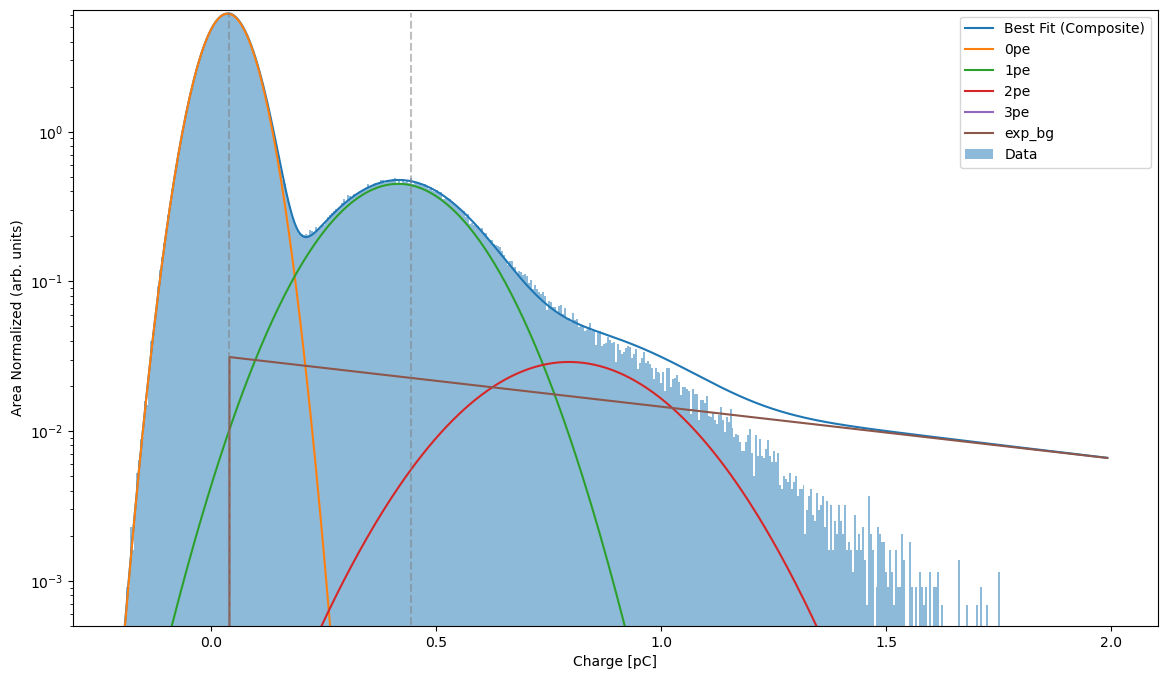

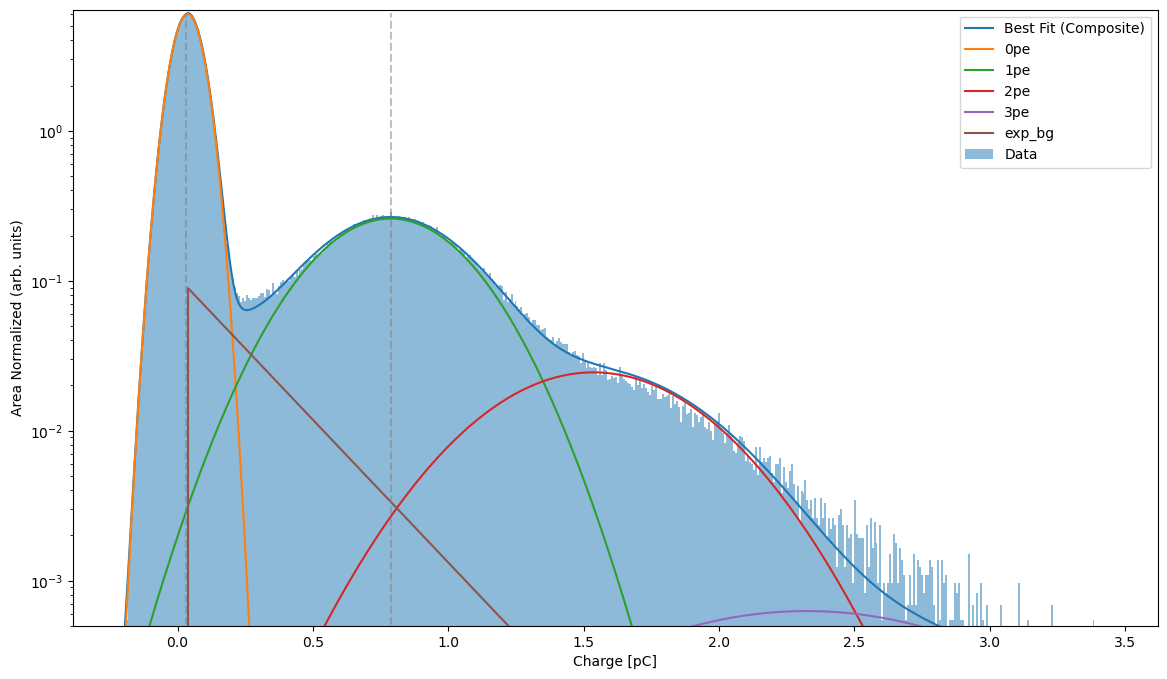

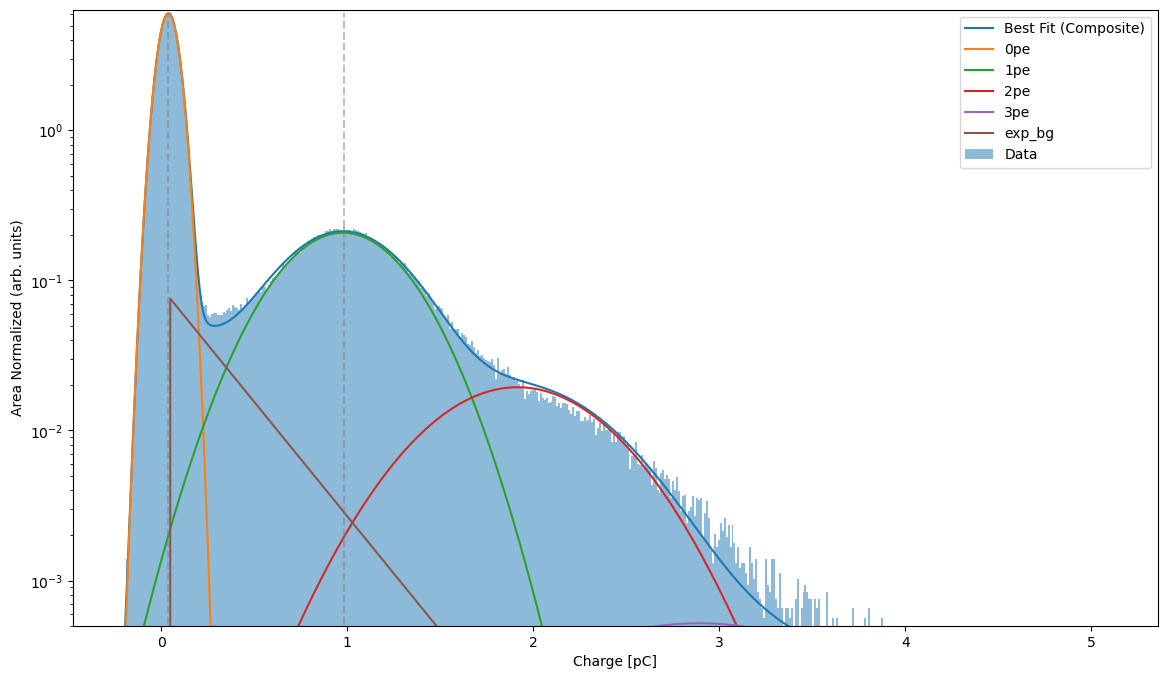

In [338]:
channel = '15'

#options = ['--q', '--save', '--save_plots', '-f', files_all, '--fit_model','luminous', '--process_ch', channel]  # Angular dependence measurement
options = ['--q', '--save', '--save_plots', '-f', files_SPE, '--fit_model','', '--process_ch', channel, '--redo_int']  # Single PE measurement
#options = ['--wf', '-f', files_sel, '--process_ch', channel]  # just plot waveforms

args = parser.parse_args(args=options)

fnames = args.file
if args.q:
    process_files_q(args)
elif args.wf:
    draw_waveforms(args)
else:
    process_files(args)